# Ablation Study: Size of the MC Variance Depending on the Dataset Size

For this study, we apply the following formula, i.e. we omit the model and thus eliminate other error sources such as model bias and variance. When transferring this to the model feature effects (PDP and ALE), this would assume a perfect model fit.

\begin{equation}
    \widehat{\text{Variance}}_{MC}(x_S; PDP_f, \widehat{PDP}_f) = \frac{1}{K}\sum_{k=1}^K(PDP_f(x_S) - \widehat{PDP}_f^{(k)}(x_S))^2
\end{equation}

Note: We only perform this ablation study only for the SimpleCombined and Friedman1 groundtruth functions, since these are the only ones for which we can derive the feature effects analytically.

Detail: We remove the first and the last point of the grid, since there are like not many data points in this quantile or it is even inf (cf. normal distribution).

In [1]:
import yaml
import os
from joblib import dump
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cm

from current_research_feature_effects.mappings import map_dataset_to_groundtruth
from current_research_feature_effects.data_generating.data_generation import generate_data, Groundtruth
from current_research_feature_effects.feature_effects import compute_theoretical_effects, compute_ales, compute_pdps

c:\Users\ti-he\OneDrive\Dokumente\Master-Studium\3. Semester\Current Research\current-research-feature-effects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EXPERIMENT_PATH = Path("../experiments/mc_ablation_study")
os.makedirs(EXPERIMENT_PATH, exist_ok=True)

In [3]:
with open("../configs/datasets.yaml", "r") as file:
    datasets_config = yaml.safe_load(file)

groundtruths = [
    map_dataset_to_groundtruth(
        config["groundtruth"],
        [(v["marginal"]["type"], tuple(v["marginal"]["params"])) for v in config["features"].values()],
        np.array(config["correlation_matrix"]),
        feature_names=list(config["features"].keys()),
        name=name,
    )
    for name, config in datasets_config.items()
]

In [4]:
N_SAMPLES = np.logspace(1, 6, num=50)
K = 50
N_GRID_POINTS = 100
BASE_SEED = 99999
quantiles = np.linspace(0.0001, 0.9999, N_GRID_POINTS, endpoint=True)

In [5]:
def perform_mc_ablation_study(groundtruth: Groundtruth, grid_values):
    feature_names = groundtruth.feature_names

    ale_groundtruth_theoretical = compute_theoretical_effects(
        groundtruth, "ale", feature_names, grid_values=grid_values, center_curves=True, remove_first_last=True
    )
    pdp_groundtruth_theoretical = compute_theoretical_effects(
        groundtruth, "pdp", feature_names, grid_values=grid_values, center_curves=True, remove_first_last=True
    )

    results = {
        "pdp": {},
        "ale": {}
    }

    for n_samples in N_SAMPLES:
        pdp_variances = defaultdict(float)
        ale_variances = defaultdict(float)
        
        for i in range(K):
            X_mc, *_ = generate_data(
                groundtruth=groundtruth, 
                n_train=int(n_samples), 
                n_test=1, 
                snr=0,
                seed=BASE_SEED + i
            )

            pdp = compute_pdps(
                groundtruth,
                X_mc,
                feature_names,
                grid_values=grid_values,
                center_curves=True,
                remove_first_last=True,
            )

            ale = compute_ales(
                groundtruth,
                X_mc,
                feature_names,
                grid_values=grid_values,
                center_curves=True,
                remove_first_last=True,
            )

            pdp_vars = {
                feature: (pdp[i]["effect"] - pdp_groundtruth_theoretical[i]["effect"]) ** 2
                for i, feature in enumerate(feature_names)
            }

            ale_vars = {
                feature: (ale[i]["effect"] - ale_groundtruth_theoretical[i]["effect"]) ** 2
                for i, feature in enumerate(feature_names)
            }

            for feature in feature_names:
                pdp_variances[feature] += pdp_vars[feature]
                ale_variances[feature] += ale_vars[feature]

        results["pdp"][n_samples] = {k: v / K for k, v in pdp_variances.items()}
        results["ale"][n_samples] = {k: v / K for k, v in ale_variances.items()}

    return results

## Simple Combined

In [ ]:
simplecomb_groundtruth = groundtruths[0]

simplecomb_grid = [simplecomb_groundtruth.get_theoretical_quantiles(feature, quantiles) for feature in simplecomb_groundtruth.feature_names]
results_simplecomb = perform_mc_ablation_study(simplecomb_groundtruth, simplecomb_grid)

In [7]:
os.makedirs(EXPERIMENT_PATH / str(simplecomb_groundtruth), exist_ok=True)
dump(results_simplecomb, EXPERIMENT_PATH / str(simplecomb_groundtruth) / "ablation_results.joblib")

['..\\experiments\\mc_ablation_study\\SimpleNormalCorrelated\\ablation_results.joblib']

## Friedman1

In [ ]:
friedman1_groundtruth = groundtruths[1]

friedman1_grid = [friedman1_groundtruth.get_theoretical_quantiles(feature, quantiles) for feature in friedman1_groundtruth.feature_names]
results_friedman1 = perform_mc_ablation_study(friedman1_groundtruth)

In [15]:
os.makedirs(EXPERIMENT_PATH / str(friedman1_groundtruth), exist_ok=True)
dump(results_friedman1, EXPERIMENT_PATH / str(friedman1_groundtruth) / "ablation_results.joblib")

['..\\experiments\\mc_ablation_study\\Friedman1\\ablation_results.joblib']

## Analysis

In [12]:
def set_style_variance_plots():
    plt.style.use("fivethirtyeight")

    plt.rcParams.update(
        {
            "axes.titlesize": 12,  # Smaller title size
            "axes.labelsize": 10,  # Smaller axis labels size
            "xtick.labelsize": 8,  # Smaller x-axis tick labels size
            "ytick.labelsize": 8,  # Smaller y-axis tick labels size
            "legend.fontsize": 10,  # Smaller legend font size
            "font.size": 10,  # This sets the overall default font size
            "grid.linewidth": 0.5,  # Thin grid lines
            "figure.facecolor": "white",  # White background color
            "figure.dpi": 300,  # Higher resolution
            "axes.facecolor": "white",  # White background color
            "axes.edgecolor": "white",  # White background edge color
            "lines.linewidth": 1.5,  # Thin edge linewidth
        }
    )

In [13]:
def plot_variance_over_features(data, grid_values, feature_names, title=None):
    set_style_variance_plots()
    n_feat = len(feature_names)
    fig, axes = plt.subplots(1, n_feat, figsize=(4 * n_feat, 4), sharey=True)
    fig.suptitle(title, y=1.02, fontsize=14, fontweight="bold")

    for f_idx, feature, ax in zip(range(n_feat), feature_names, axes):
        norm = colors.LogNorm(vmin=min(N_SAMPLES), vmax=max(N_SAMPLES))
        cmap = cm.viridis

        for n_samples in N_SAMPLES:
            color = cmap(norm(n_samples))
            ax.plot(grid_values[f_idx], data[n_samples][feature], color=color)
            ax.fill_between(grid_values[f_idx], data[n_samples][feature], alpha=0.1, color=color)
        ax.set_title(f"MC Variance ${feature}$")
        ax.set_xlabel(feature)
        ax.set_ylabel("MC Variance")

    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    plt.colorbar(sm, ax=axes[-1], label="$n_{mc}$")

    return fig

In [15]:
simplecomb_grid_stripped = [simplecomb_groundtruth.get_theoretical_quantiles(feature, quantiles)[1:-1] for feature in simplecomb_groundtruth.feature_names]

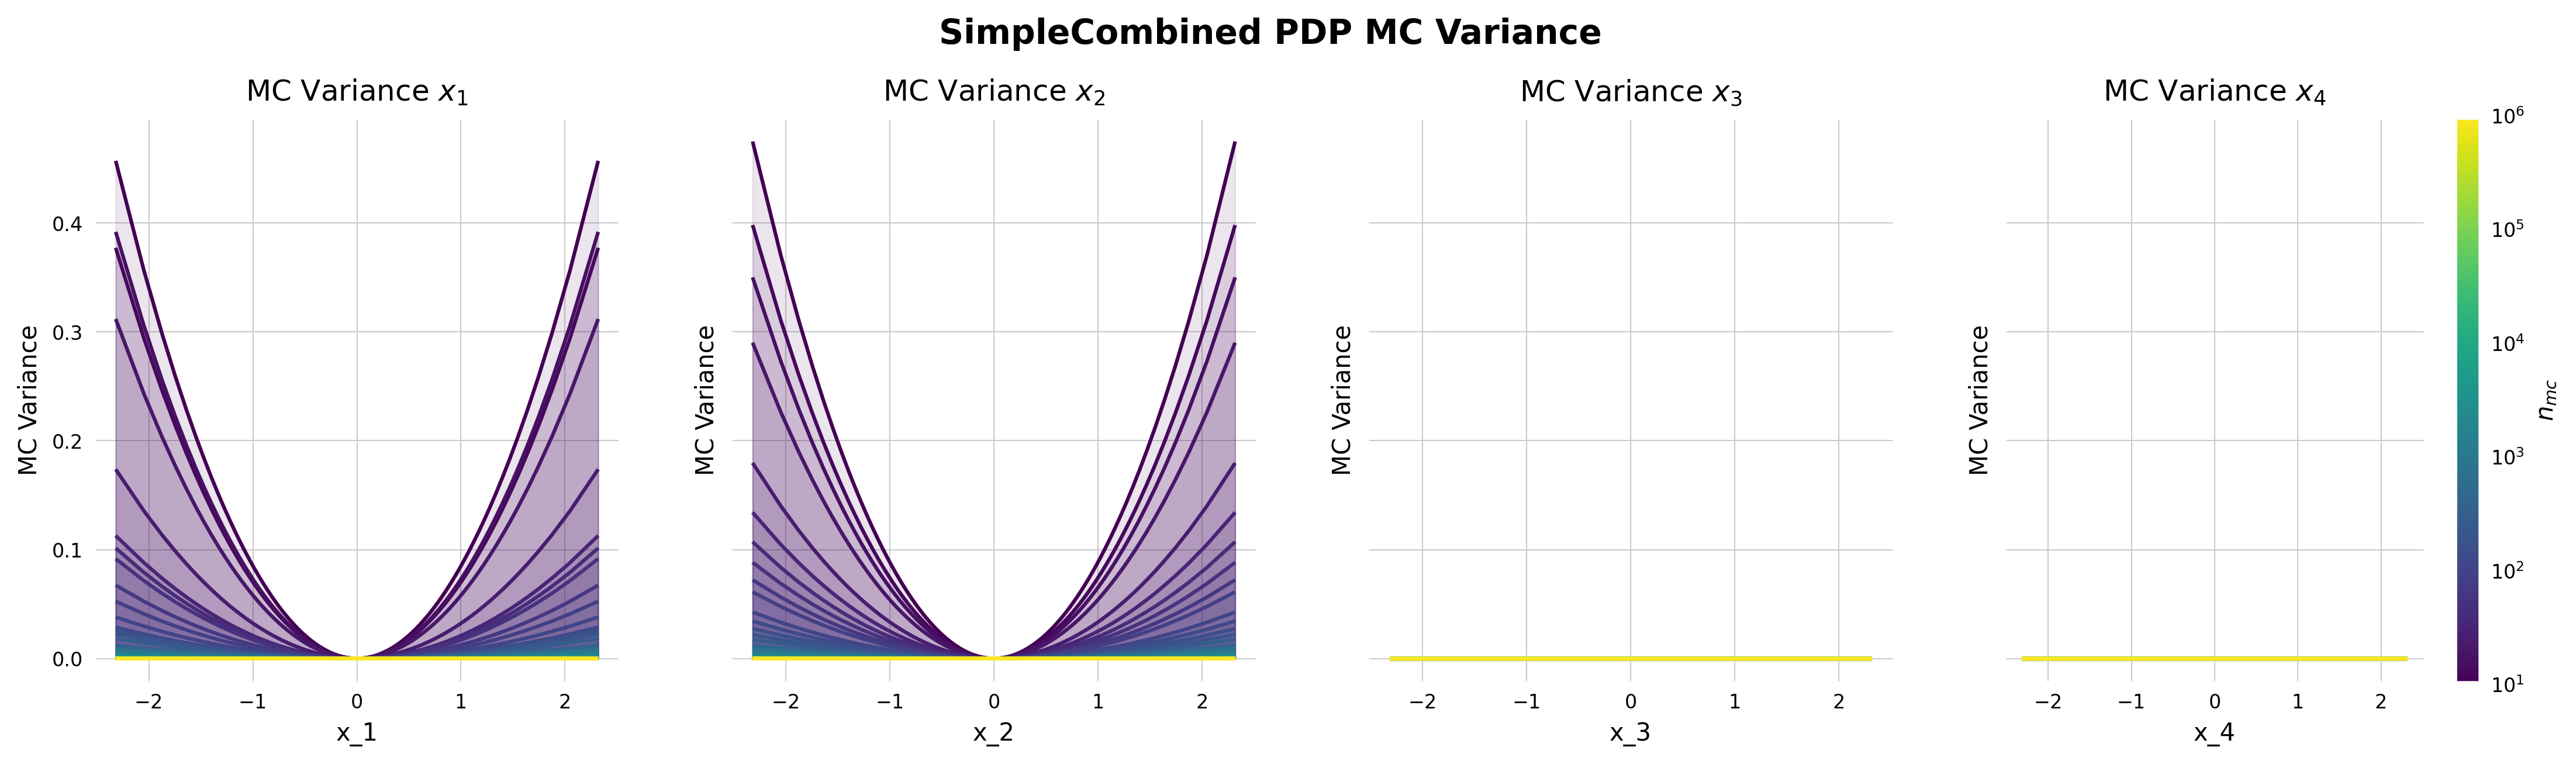

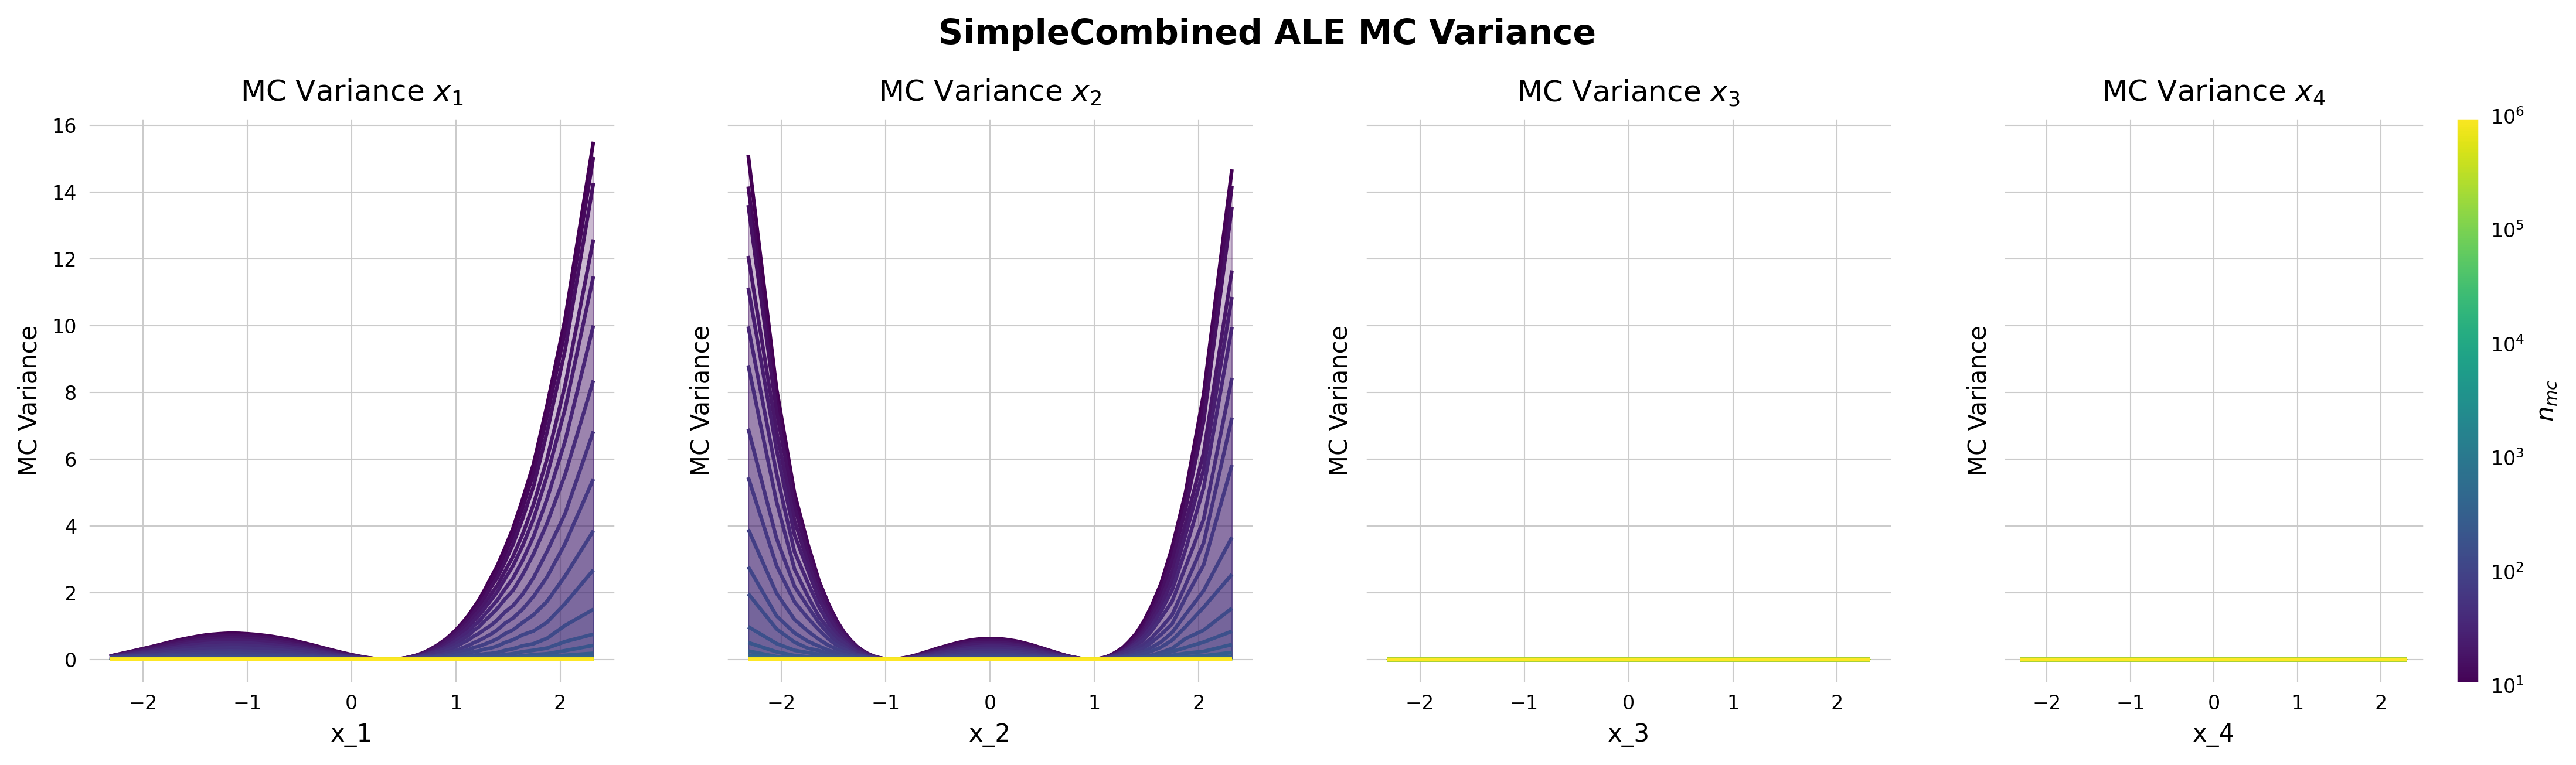

In [17]:
plot_variance_over_features(
    results_simplecomb["pdp"], simplecomb_grid_stripped, simplecomb_groundtruth.feature_names, title=f"SimpleCombined PDP MC Variance"
)
plot_variance_over_features(
    results_simplecomb["ale"], simplecomb_grid_stripped, simplecomb_groundtruth.feature_names, title=f"SimpleCombined ALE MC Variance"
)
plt.show()

In [117]:
friedman1_grid_stripped = [
    friedman1_groundtruth.get_theoretical_quantiles(feature, quantiles)[1:-1]
    for feature in friedman1_groundtruth.feature_names
]

In [ ]:
plot_variance_over_features(
    results_friedman1["pdp"], friedman1_grid_stripped, friedman1_groundtruth.feature_names, title=f"Friedman1 PDP MC Variance"
)
plot_variance_over_features(
    results_friedman1["ale"], friedman1_grid_stripped, friedman1_groundtruth.feature_names, title=f"Friedman1 ALE MC Variance"
)
plt.show()

In [37]:
def plot_variance_mean(data, feature_names, title=None):
    set_style_variance_plots()
    n_feat = len(feature_names)
    fig, axes = plt.subplots(1, n_feat, figsize=(4*n_feat, 4), ) #sharey=True
    fig.suptitle(title, y=1.02, fontsize=14, fontweight="bold")
    for feature, ax in zip(feature_names, axes):
        means = []
        for n_samples in N_SAMPLES:
            means.append(np.mean(data[n_samples][feature]))
        ax.plot(N_SAMPLES, means, marker='+')
        ax.set_yscale("log")
        ax.set_title(f"MC Variance ${feature}$")
        ax.set_xlabel("$n_{mc}$")
        ax.set_ylabel("Mean MC Variance")
    return fig

C:\Users\ti-he\AppData\Local\Temp\ipykernel_20936\931060484.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


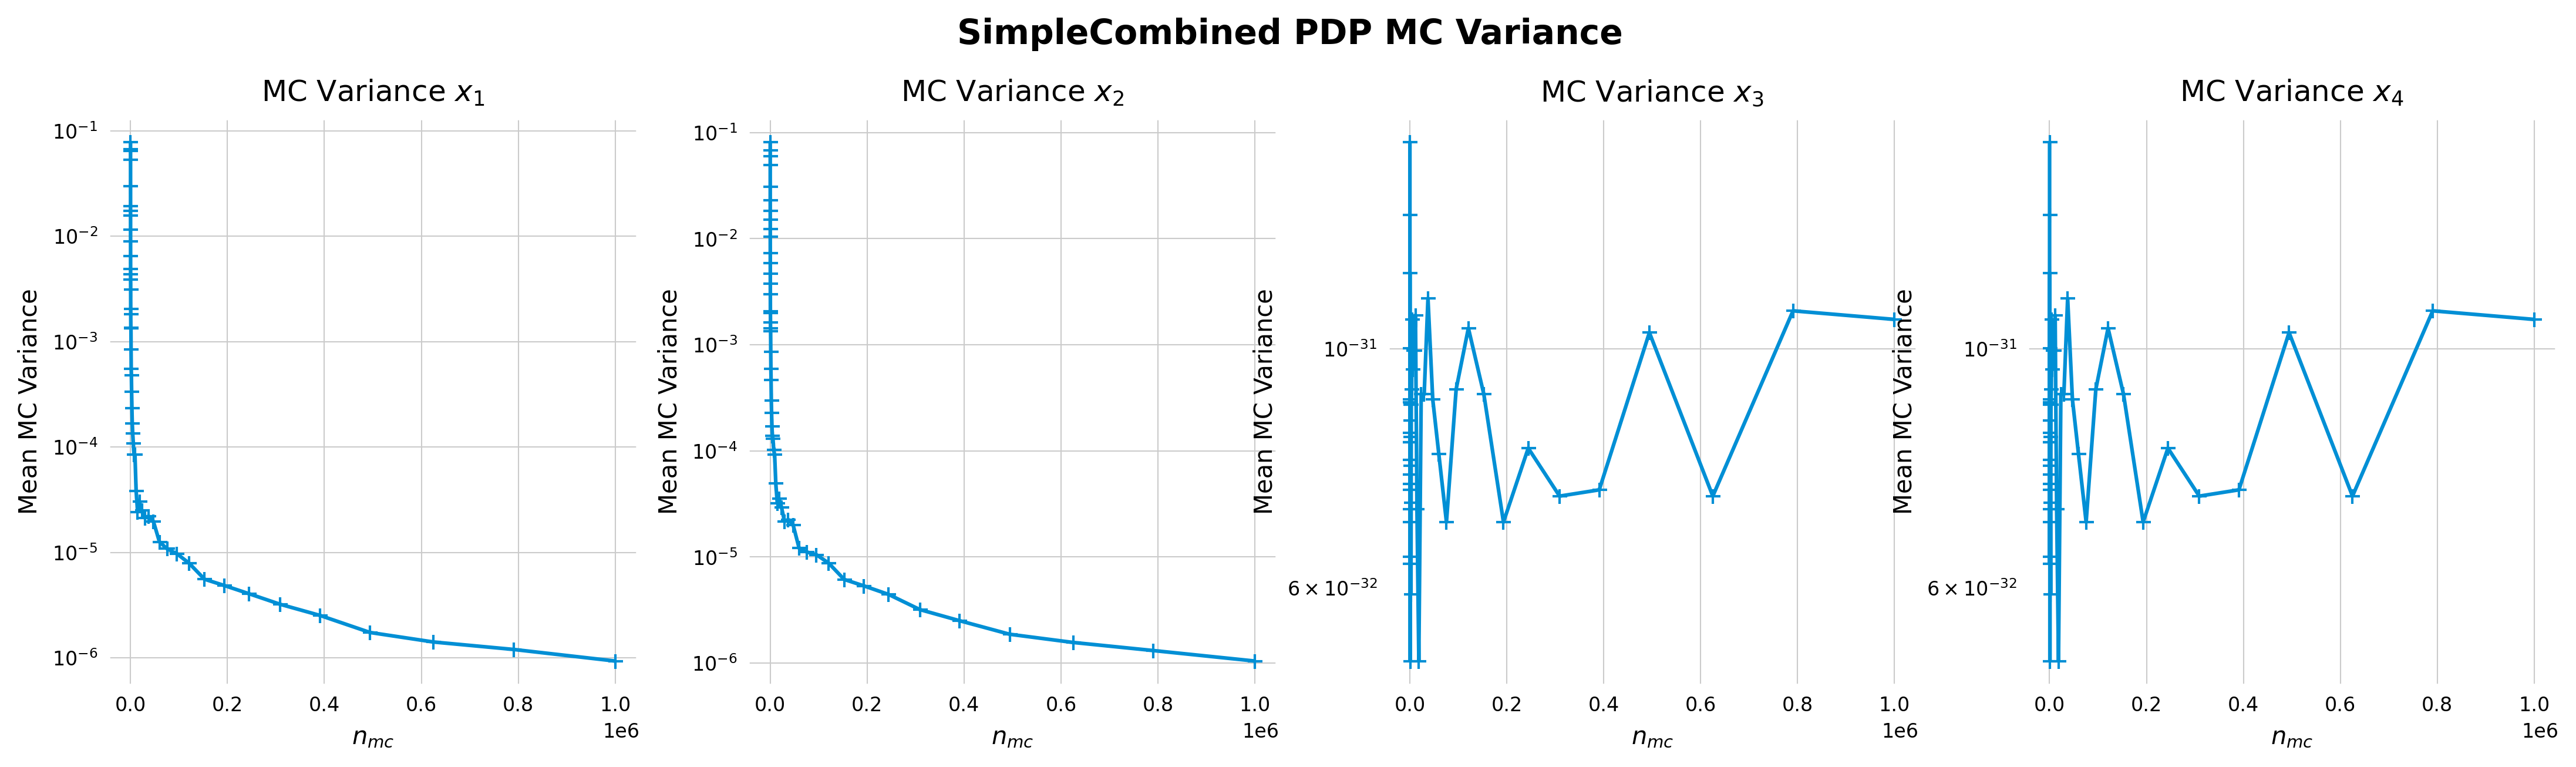

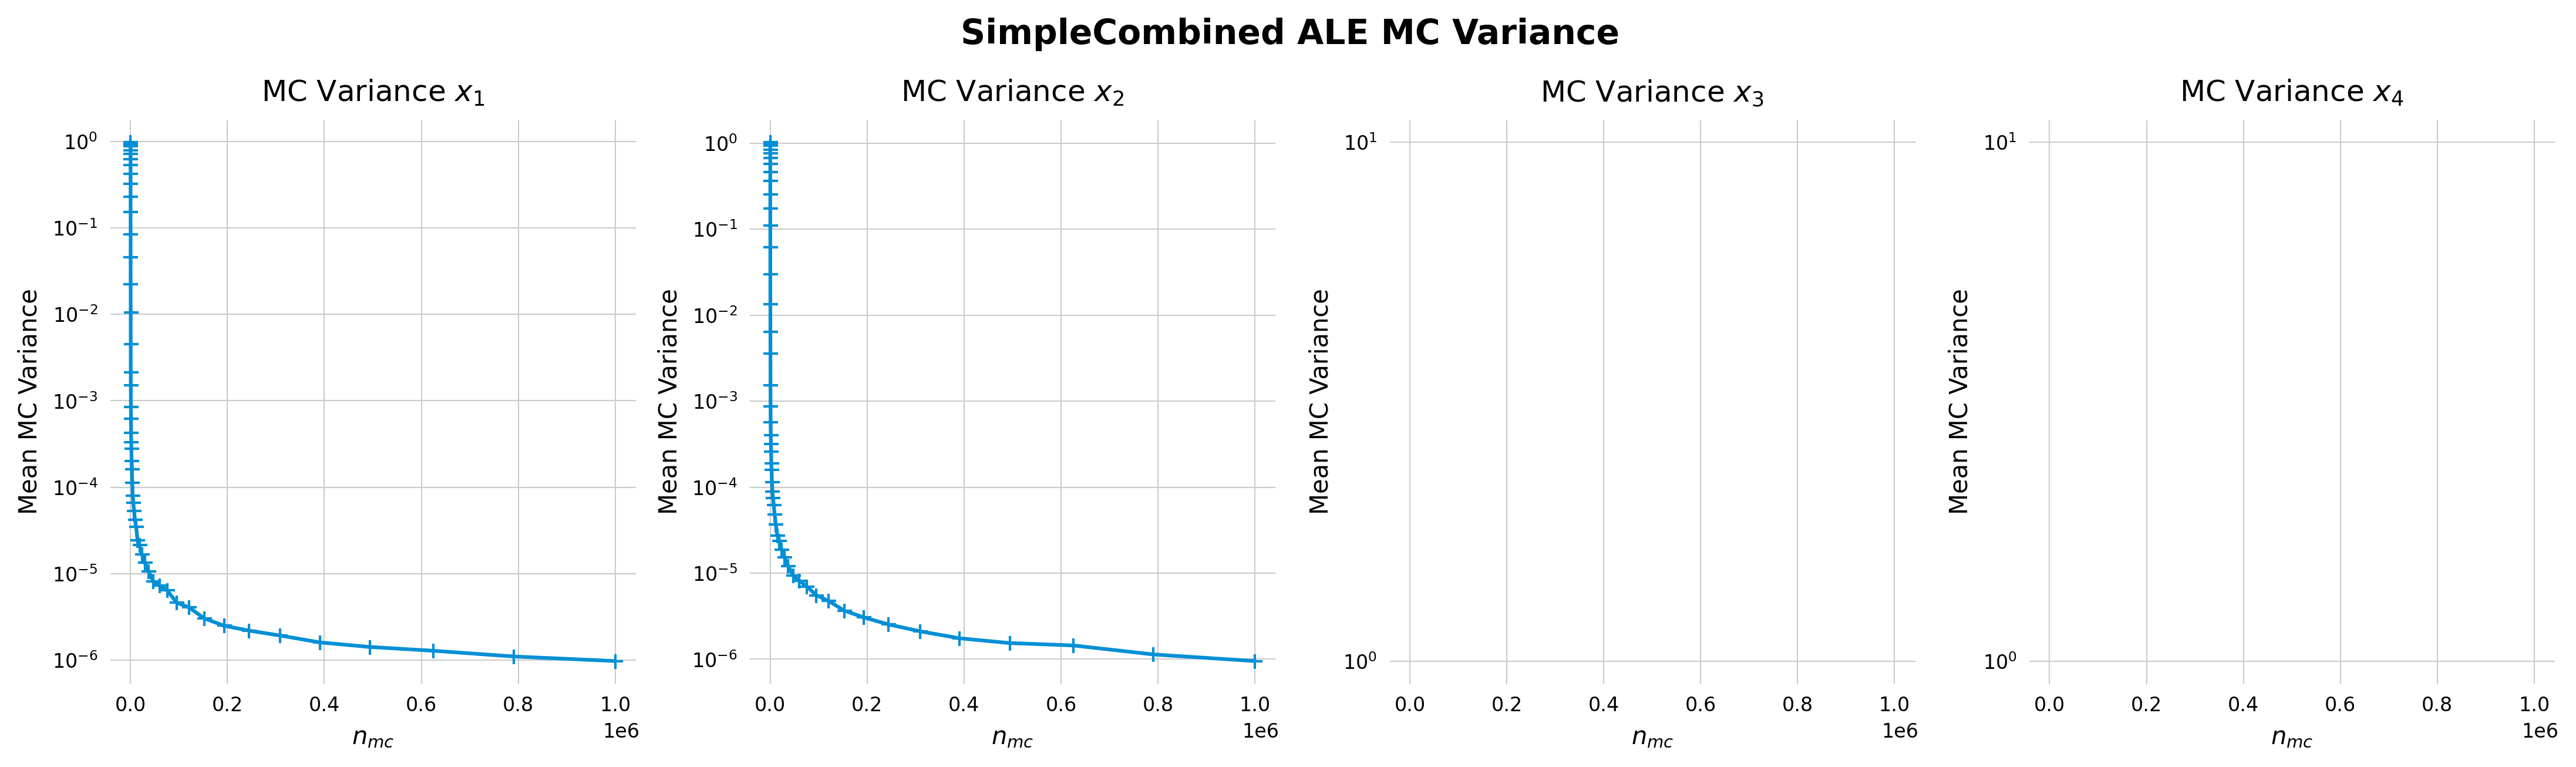

In [38]:
plot_variance_mean(results_simplecomb["pdp"], simplecomb_groundtruth.feature_names, title=f"SimpleCombined PDP MC Variance")
plot_variance_mean(results_simplecomb["ale"], simplecomb_groundtruth.feature_names, title=f"SimpleCombined ALE MC Variance")
plt.show()